In [129]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision.transforms.functional as TF
from torchvision import models 
from torch.autograd import Variable

import pandas as pd 
import numpy as np 
import os
from PIL import Image
import matplotlib.pyplot as plt

In [136]:
!pip install opencv-python

     |████████████████████████████████| 53.9 MB 253 kB/s eta 0:00:011


In [137]:
import cv2

CAM models provide interpretability to AI, this had important ramifications in for three areas in ai 
-  Identify why a model is not providing the desired result 
-  Understanding the result of the model. Increase customer trust 
-  Training 

The concept behind a CAM-type model logic seems fairly trivial. The outputs of a convolution layer (before applying any downsampling activation function) will correspond to the 'weight maps' for the input. What does this mean?

The last convolutional layer will output k feature maps, where k is the number of kernels or filters in the layer. Each feature map (A_k) is the result of the convolution of the input to the layer with the kernel k. In CAM, the feature map is turned into a k-dimensional vector g though a global average pooling layer and converted into class scores (y_c) for each class c, in the fully connected layer. 

Grad-CAM does not require the last fully convolutional layer. Thereby, the impact/importance of the activation layer into the final score, also called the neuron activation, can be computed as:  

                            α_c,k = (1 / (H * W)) * Σ(Σ(∂y_c/∂A^(L)_k(i, j)))



In [2]:
# Foundation 

- backprop
- compute dy/dA 
- compute alpha_c
- compute the gradients 

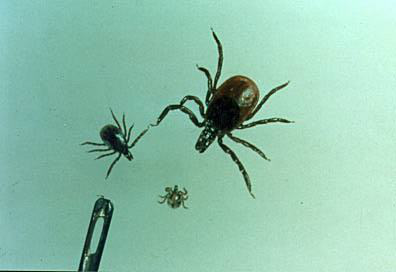

In [12]:
ROOT_DIR = os.path.abspath(os.path.dirname(__name__))
img = Image.open(os.path.join(ROOT_DIR, 'Data', os.listdir('Data')[0]))
img

In [89]:
# Implementation using hooks 
class ConvNeXt(nn.Module):
    
    def __init__(self):
        super(ConvNeXt, self).__init__()
        
        # weights 
        self.convnet = models.convnext_base(weights="IMAGENET1K_V1")
        
        # get the network up until the last conv layer
        self.feature_map_A = self.convnet.features[:8]
        
        # fininsh the network  
        self.pool = self.convnet.avgpool
        self.classifier = self.convnet.classifier 
#         self.tail = self.convnet.features[8:]
        
        #gradients
        self.gradients = None 
    
    #compute the ∂y_c/∂A
    def activations_hook(self, grad):
        self.gradients = grad
    
    def forward(self, x):
        x = self.feature_map_A(x)
        
        h = x.register_hook(self.activations_hook)
        
        x = self.pool(x)
        x = self.classifier(x)
        
        return x
    
    def get_activation_gradients(self):
        return self.gradients
    
    def get_A(self, x):
        return self.feature_map_A(x)
        

In [90]:
cnv = ConvNeXt()
cnv.eval()

models.ConvNeXt_Base_Weights.IMAGENET1K_V1
preprocess = weights.transforms()
batch = preprocess(img).unsqueeze(0)

78 0.7106282114982605
torch.Size([1, 1024, 7, 7])
torch.Size([1, 1024])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 1024, 7, 7])


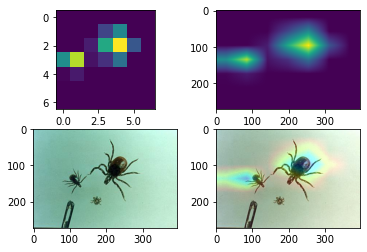

In [179]:
pred = cnv(batch).squeeze(0).softmax(0)
class_id = pred.argmax().item()
score = pred[class_id].item()

print(class_id, score)

# cnv.zero_grad()
pred[class_id].backward()

gradients = cnv.gradients # gradients shape: (N, K, H, W); N = batch size ,  K is the number of feature maps (channels) in the last convolutional layer, and H' and W' are the height and width of the feature maps, respectively
print(np.shape(gradients))

#global avg pooling along H and W of the feature map
pool_gradients = torch.mean(gradients, dim=(2, 3))  #
#Shape: (K,) -> pools the gradients across the channels 
print(np.shape(pool_gradients))

activations = cnv.feature_map_A(batch).detach()
print(np.shape(activations)) #activation shape: (K, H, W)

for i in range(activations.size()[1]): #K
    activations[:, i, :, :] *= pool_gradients[:, i] #weigh each activation by the wights 

cam = torch.mean(activations, dim=1).squeeze()

cam = np.maximum(cam, 0) #ReLu
cam /= torch.max(cam) #normalize

fig, axs = plt.subplots(nrows=2, ncols=2)
axs[0, 0].imshow(cam.squeeze())
resized_cam = cv2.resize(cam.squeeze().numpy(), img.size)
axs[0, 1].imshow(resized_cam)
axs[1, 0].imshow(img)
superimposed_img = cv2.applyColorMap(np.uint8(resized_cam*255), cv2.COLORMAP_JET) * 0.001 + np.array(img)/255
axs[1, 1].imshow(superimposed_img)

In [125]:
img.size

(396, 272)

In [40]:
model

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

In [ ]:
# Foundation toy model 

- compute dy/dA 
- compute alpha_c
- compute the gradients 

In [31]:
import torchvision.transforms as transforms

t = transforms.PILToTensor()
tensor_img = t(img)

tensor_img.required_grad = True

output = model


tensor([[[ 10,  20,  18,  ...,  16,   9,  12],
         [ 19,  21,  18,  ...,  13,  17,   9],
         [ 16,  16,  14,  ...,   5,  17,   8],
         ...,
         [113, 116, 117,  ...,   8,   6,  16],
         [127, 121, 124,  ...,   7,   1,  18],
         [130, 137, 125,  ...,  10,  10,  14]],

        [[ 81,  95,  99,  ...,  98,  89,  91],
         [ 78,  86,  89,  ...,  99, 101,  94],
         [ 70,  76,  79,  ...,  93, 103,  93],
         ...,
         [161, 164, 166,  ...,  78,  69,  69],
         [171, 165, 167,  ...,  72,  58,  68],
         [161, 172, 168,  ...,  70,  63,  63]],

        [[ 77,  91,  93,  ...,  96,  86,  86],
         [ 84,  92,  93,  ...,  98, 101,  91],
         [ 70,  77,  81,  ...,  94, 104,  96],
         ...,
         [161, 166, 170,  ...,  80,  74,  77],
         [170, 168, 173,  ...,  76,  65,  79],
         [164, 178, 175,  ...,  81,  77,  78]]], dtype=torch.uint8)

In [2]:
# Toy sample model - Based on classifier architecture


/Users/aina/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/aina/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/aina/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [18]:
model.layer4

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
weights  = fc.weight
cam = torch.matmul(weights, features_map_view(512,-1))